# Compile and Train a Vision Transformer Model on the Caltech-256 Dataset using a Single-Node Multi-GPU

1. [Introduction](#Introduction)  
2. [Development Environment and Permissions](#Development-Environment-and-Permissions)
    1. [Installation](#Installation)  
    2. [SageMaker environment](#SageMaker-environment)
3. [Working with the Caltech-256 dataset](#Working-with-the-Caltech-256-dataset)   
4. [SageMaker Training Job](#SageMaker-Training-Job)  
    1. [Training Setup](#Training-Setup)  
    2. [Training with Native TensorFlow](#Training-with-Native-TensorFlow)  
    3. [Training with Optimized TensorFlow](#Training-with-Optimized-TensorFlow)  
5. [Analysis](#Analysis)
    1. [Savings from Training Compiler](#Savings-from-Training-Compiler)
    2. [Convergence of Training](#Convergence-of-Training)
6. [Clean up](#Clean-up)


## SageMaker Training Compiler Overview

SageMaker Training Compiler is a capability of SageMaker that makes hard-to-implement optimizations to reduce training time on GPU instances. The compiler optimizes Deep Learning (DL) models to accelerate training by more efficiently using SageMaker machine learning (ML) GPU instances. SageMaker Training Compiler is available at no additional charge within SageMaker and can help reduce total billable time as it accelerates training. 

SageMaker Training Compiler is integrated into the AWS Deep Learning Containers (DLCs). Using the SageMaker Training Compiler enabled AWS DLCs, you can compile and optimize training jobs on GPU instances with minimal changes to your code. Bring your deep learning models to SageMaker and enable SageMaker Training Compiler to accelerate the speed of your training job on SageMaker ML instances for accelerated computing. 

For more information, see [SageMaker Training Compiler](https://docs.aws.amazon.com/sagemaker/latest/dg/training-compiler.html) in the *Amazon SageMaker Developer Guide*.

## Introduction

In this demo, you'll use Amazon SageMaker Training Compiler to train the `Vision Transformer` model on the `Caltech-256` dataset. To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on. 

**NOTE:** You can run this demo in SageMaker Studio, SageMaker notebook instances, or your local machine with AWS CLI set up. If using SageMaker Studio or SageMaker notebook instances, make sure you choose one of the TensorFlow-based kernels, `Python 3 (TensorFlow x.y Python 3.x CPU Optimized)` or `conda_tesorflow_p39` respectively.

**NOTE:** This notebook uses a `ml.p3.8xlarge` instance with multiple GPUs. If you don't have enough quota, see [Request a service quota increase for SageMaker resources](https://docs.aws.amazon.com/sagemaker/latest/dg/regions-quotas.html#service-limit-increase-request-procedure). 

## Development Environment 


### Installation

This example notebook requires **SageMaker Python SDK v2.92.0 or later**


In [1]:
!pip install "sagemaker>=2.92" botocore boto3 awscli matplotlib --upgrade

In [2]:
import botocore
import boto3
import sagemaker

print(f"botocore: {botocore.__version__}")
print(f"boto3: {boto3.__version__}")
print(f"sagemaker: {sagemaker.__version__}")

botocore: 1.26.10
boto3: 1.23.10
sagemaker: 2.94.0


### SageMaker environment 

In [3]:
import sagemaker

sess = sagemaker.Session()

# SageMaker session bucket -> used for uploading data, models and logs
# SageMaker will automatically create this bucket if it does not exist
sagemaker_session_bucket = None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sagemaker_session_bucket}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::875423407011:role/service-role/AmazonSageMaker-ExecutionRole-20220609T112287
sagemaker bucket: sagemaker-us-west-2-875423407011
sagemaker session region: us-west-2


## Working with the Caltech-256 dataset

We have hosted the [Caltech-256](https://authors.library.caltech.edu/7694/) dataset in S3 in us-east-1. We will transfer this dataset to your account and region for use with SageMaker Training.

The dataset consists of JPEG images organized into directories with each directory representing an object category.

In [4]:
import os

source = "s3://sagemaker-sample-files/datasets/image/caltech-256/256_ObjectCategories"
destn = f"s3://{sagemaker_session_bucket}/caltech-256"
local = "caltech-256"

os.system(f"aws s3 sync {source} {local}")
os.system(f"aws s3 sync {local} {destn}")

0

## SageMaker Training Job

To create a SageMaker training job, we use a `TensorFlow` estimator. Using the estimator, you can define which training script should SageMaker use through `entry_point`, which `instance_type` to use for training, which `hyperparameters` to pass, and so on.

When a SageMaker training job starts, SageMaker takes care of starting and managing all the required machine learning instances, picks up the `TensorFlow` Deep Learning Container, uploads your training script, and downloads the data from `sagemaker_session_bucket` into the container at `/opt/ml/input/data`.

In the following section, you learn how to set up two versions of the SageMaker `TensorFlow` estimator, a native one without the compiler and an optimized one with the compiler.

### Training Setup

Set up the basic configuration for training. Set `EPOCHS` to the number of times you would like to loop over the training data.

In [5]:
TRCOMP_IMAGE_URI = "763104351884.dkr.ecr.us-west-2.amazonaws.com/tensorflow-training:2.9.1-gpu-py39-cu112-ubuntu20.04-sagemaker"
EPOCHS = 10

num_gpus_per_instance = 4

### Training with Native TensorFlow

The `BATCH_SIZE` in the following code cell is the maximum batch that can fit into the memory of a `ml.p3.8xlarge` instance while giving the best training speed. If you change the model, instance type, and other parameters, you need to do some experiments to find the largest batch size that will fit into GPU memory.

In [6]:
from sagemaker.tensorflow import TensorFlow

BATCH_SIZE = 64 * num_gpus_per_instance
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

kwargs = dict(
    source_dir="scripts",
    entry_point="vit.py",
    model_dir=False,
    instance_type="ml.p3.8xlarge",
    instance_count=1,
    image_uri=TRCOMP_IMAGE_URI,
    debugger_hook_config=None,
    disable_profiler=True,
    max_run=60 * 60,  # 60 minutes
    role=role,
    metric_definitions=[
        {"Name": "training_loss", "Regex": "loss: ([0-9.]*?) "},
        {"Name": "training_accuracy", "Regex": "accuracy: ([0-9.]*?) "},
        {"Name": "training_latency_per_epoch", "Regex": "- ([0-9.]*?)s/epoch"},
        {"Name": "training_avg_latency_per_step", "Regex": "- ([0-9.]*?)ms/step"},
    ],
)

# Configure the training job
native_estimator = TensorFlow(
    hyperparameters={
        "EPOCHS": EPOCHS,
        "BATCH_SIZE": BATCH_SIZE,
        "LEARNING_RATE": LEARNING_RATE,
        "WEIGHT_DECAY": WEIGHT_DECAY,
    },
    base_job_name="native-tf29-vit",
    **kwargs,
)

# Start training with our uploaded datasets as input
native_estimator.fit(inputs=destn, wait=False)

# The name of the training job.
native_estimator.latest_training_job.name

'native-tf29-vit-2022-06-15-23-00-09-607'

### Training with Optimized TensorFlow

Compilation through Training Compiler changes the memory footprint of the model. Most commonly, this manifests as a reduction in memory utilization and a consequent increase in the largest batch size that can fit on the GPU. But in some cases the compiler intelligently promotes caching which leads to a decrease in the largest batch size that can fit on the GPU. Note that if you want to change the batch size, you must adjust the learning rate appropriately.

**Note:** We recommend you to turn the SageMaker Debugger's profiling and debugging tools off when you use compilation to avoid additional overheads.

In [7]:
# TODO: Change how TrainingCompilerConfig is used after SDK release

from sagemaker.tensorflow import TensorFlow
from sagemaker.training_compiler.config import TrainingCompilerConfig

OPTIMIZED_BATCH_SIZE = 48 * num_gpus_per_instance
LEARNING_RATE = LEARNING_RATE / BATCH_SIZE * OPTIMIZED_BATCH_SIZE
WEIGHT_DECAY = WEIGHT_DECAY * BATCH_SIZE / OPTIMIZED_BATCH_SIZE

# Configure the training job
optimized_estimator = TensorFlow(
    hyperparameters={
        TrainingCompilerConfig.HP_ENABLE_COMPILER: True,
        "EPOCHS": EPOCHS,
        "BATCH_SIZE": OPTIMIZED_BATCH_SIZE,
        "LEARNING_RATE": LEARNING_RATE,
        "WEIGHT_DECAY": WEIGHT_DECAY,
    },
    base_job_name="optimized-tf29-vit",
    **kwargs,
)

# Start training with our uploaded datasets as input
optimized_estimator.fit(inputs=destn, wait=False)

# The name of the training job.
optimized_estimator.latest_training_job.name

'optimized-tf29-vit-2022-06-15-23-00-10-246'

### Wait for training jobs to complete

The training jobs described above typically take around 40 mins to complete

**Note:** If the estimator object is no longer available due to a kernel break or refresh, you need to directly use the training job name and manually attach the training job to a new TensorFlow estimator. For example:

```python
native_estimator = TensorFlow.attach("<your_training_job_name>")
```

In [8]:
native_estimator = TensorFlow.attach(native_estimator.latest_training_job.name)
optimized_estimator = TensorFlow.attach(optimized_estimator.latest_training_job.name)


2022-06-15 23:00:10 Starting - Starting the training job.........
2022-06-15 23:00:59 Starting - Preparing the instances for training...............
2022-06-15 23:02:16 Downloading - Downloading input data...........................................
2022-06-15 23:06:02 Training - Downloading the training image......
2022-06-15 23:06:33 Training - Training image download completed. Training in progress...................................................................................................................................
2022-06-15 23:17:31 Uploading - Uploading generated training model
2022-06-15 23:17:37 Completed - Training job completed

2022-06-15 23:16:17 Starting - Preparing the instances for training
2022-06-15 23:16:17 Downloading - Downloading input data
2022-06-15 23:16:17 Training - Training image download completed. Training in progress.
2022-06-15 23:16:17 Uploading - Uploading generated training model
2022-06-15 23:16:17 Completed - Training job completed


## Analysis

Here we view the training metrics from the training jobs as a Pandas dataframe

#### Native TensorFlow

In [18]:
import pandas as pd

# Extract training metrics from the estimator
native_metrics = native_estimator.training_job_analytics.dataframe()

# Restructure table for viewing
for metric in native_metrics["metric_name"].unique():
    native_metrics[metric] = native_metrics[native_metrics["metric_name"] == metric]["value"]
native_metrics = native_metrics.drop(columns=["metric_name", "value"])
native_metrics = native_metrics.groupby("timestamp").max()
# SageMaker Training metrics are captured at a resolution of 1 minute. Metrics might not be captured for every single epoch
# native_metrics["epochs"] = range(1, 11)
# native_metrics = native_metrics.set_index("epochs")

native_metrics

,training_loss,training_accuracy,training_latency_per_epoch,training_avg_latency_per_step
timestamp,,,,
0.0,5.64200,0.02240,164.0,442.5
60.0,5.57680,0.02605,32.0,442.0
120.0,5.54985,0.02770,32.0,443.0
180.0,5.54090,0.02895,32.0,442.5
240.0,5.54125,0.02940,32.0,443.0
300.0,5.52580,0.03050,32.0,NaN


#### Optimized TensorFlow

In [19]:
import pandas as pd

# Extract training metrics from the estimator
optimized_metrics = optimized_estimator.training_job_analytics.dataframe()

# Restructure table for viewing
for metric in optimized_metrics["metric_name"].unique():
    optimized_metrics[metric] = optimized_metrics[optimized_metrics["metric_name"] == metric][
        "value"
    ]
optimized_metrics = optimized_metrics.drop(columns=["metric_name", "value"])
optimized_metrics = optimized_metrics.groupby("timestamp").max()
# SageMaker Training metrics are captured at a resolution of 1 minute. Metrics might not be captured for every single epoch
# optimized_metrics["epochs"] = range(1, 11)
# optimized_metrics = optimized_metrics.set_index("epochs")

optimized_metrics

,training_loss,training_accuracy,training_latency_per_epoch,training_avg_latency_per_step
timestamp,,,,
0.0,5.616000,0.025100,173.000000,216.666667
60.0,5.542433,0.027833,20.666667,219.500000
120.0,5.525200,0.029150,21.000000,212.000000
180.0,5.514533,0.029667,20.000000,211.000000
240.0,5.511400,0.028900,20.000000,NaN


### Savings from Training Compiler

Let us calculate the actual savings on the training jobs above and the potential for savings for a longer training job.

#### Actual Savings

To get the actual savings, we use the describe_training_job API to get the billable seconds for each training job.

In [20]:
# Billable seconds for the Native TensorFlow Training job

details = sess.describe_training_job(job_name=native_estimator.latest_training_job.name)
native_secs = details["BillableTimeInSeconds"]

native_secs

921

In [21]:
# Billable seconds for the Optimized TensorFlow Training job

details = sess.describe_training_job(job_name=optimized_estimator.latest_training_job.name)
optimized_secs = details["BillableTimeInSeconds"]

optimized_secs

845

In [22]:
# Calculating percentage Savings from Training Compiler

percentage = (native_secs - optimized_secs) * 100 / native_secs

f"Training Compiler yielded {percentage:.2f}% savings in training cost."

'Training Compiler yielded 8.25% savings in training cost.'

#### Potential savings

The Training Compiler works by compiling the model graph once per input shape and reusing the cached graph for subsequent steps. As a result the first few steps of training incur an increased latency owing to compilation which we refer to as the compilation overhead. This overhead is amortized over time thanks to the subsequent steps being much faster. We will demonstrate this below.

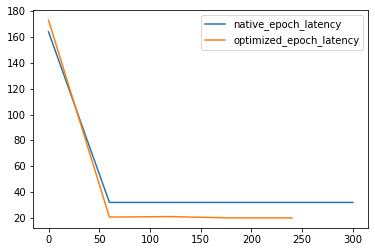

In [23]:
import matplotlib.pyplot as plt

plt.plot(native_metrics["training_latency_per_epoch"], label="native_epoch_latency")
plt.plot(optimized_metrics["training_latency_per_epoch"], label="optimized_epoch_latency")
plt.legend()

We calculate the potential savings below from the difference in steady state epoch latency between native TensorFlow and optimized TensorFlow

In [24]:
native_steady_state_latency = native_metrics["training_latency_per_epoch"].iloc[-1]

native_steady_state_latency

32.0

In [25]:
optimized_steady_state_latency = optimized_metrics["training_latency_per_epoch"].iloc[-1]

optimized_steady_state_latency

20.0

In [26]:
# Calculating potential percentage Savings from Training Compiler

percentage = (
    (native_steady_state_latency - optimized_steady_state_latency)
    * 100
    / native_steady_state_latency
)

f"Training Compiler can potentially yield {percentage:.2f}% savings in training cost for a longer training job."

'Training Compiler can potentially yield 37.50% savings in training cost for a longer training job.'

### Convergence of Training

Training Compiler brings down total training time by intelligently choosing between memory utilization and core utilization in the GPU. This does not have any effect on the model arithmetic and consequently convergence of the model.

However, since we are working with a new batch size, hyperparameters like - learning rate, learning rate schedule and weight decay might have to be scaled and tuned for the new batch size

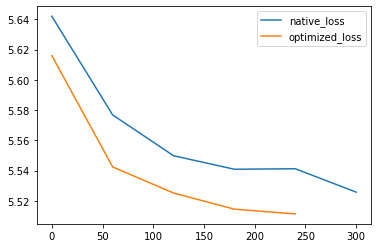

In [27]:
import matplotlib.pyplot as plt

plt.plot(native_metrics["training_loss"], label="native_loss")
plt.plot(optimized_metrics["training_loss"], label="optimized_loss")
plt.legend()

We can see that the model's convergence behavior is similar with and without Training Compiler. Here we have tuned the batch size specific hyperparameters - Learning Rate and Weight Decay using a linear scaling.

Learning rate is directly proportional to the batch size:
```python
new_learning_rate = old_learning_rate * new_batch_size/old_batch_size
```

Weight decay is inversely proportional to the batch size:
```python
new_weight_decay = old_weight_decay * old_batch_size/new_batch_size
```

Better results can be achieved with further tuning. Check out [Automatic Model Tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html) for tuning.

## Clean up

Stop all training jobs launched if the jobs are still running.

In [ ]:
def stop_training_job(name):
    status = sess.describe_training_job(name)["TrainingJobStatus"]
    if status == "InProgress":
        sm.stop_training_job(TrainingJobName=name)


stop_training_job(native_estimator.latest_training_job.name)
stop_training_job(optimized_estimator.latest_training_job.name)

Also, to find instructions on cleaning up resources, see [Clean Up](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html) in the *Amazon SageMaker Developer Guide*.